#Dataset

In [3]:
import torch
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm
import random

In [43]:
pip install transformers

In [4]:
from google.colab import drive
drive.mount('//content//drive')

Drive already mounted at //content//drive; to attempt to forcibly remount, call drive.mount("//content//drive", force_remount=True).


In [5]:
df=pd.read_csv("/content/drive/MyDrive/df_resampled.csv")

In [6]:
df

tweets  category  label
0      خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...       SAD      0
1         از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم      HATE      1
2       کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم ...       SAD      0
3      چون همش با دوربین ثبت شده  ایا میشه اعتراض زد ...     OTHER      2
4                     اين وضع ب طرز خنده داري گريه داره        SAD      0
...                                                  ...       ...    ...
12994                              عجب حرکتی  کیش و مات   SURPRISE      6
12995                             مگه اسم تعیین کنندهس    SURPRISE      6
12996        واقعا ادم حیرت میکنه از این سخنان نابخردانه  SURPRISE      6
12997  من نمیدونم از خودم برای دیگران چه تصویری ساخته...  SURPRISE      6
12998                جاااااآن  واسه کجای پایینتون دقیقا   SURPRISE      6

[12999 rows x 3 columns]

In [47]:
!pip install shap

# Create a 85-15 train-test split.



In [11]:
import numpy as np
df_train, df_test = np.split(df.sample(frac=1, random_state=4040), [int(.85*len(df))])
print('{:>5,} training samples'.format(len(df_train)))
print('{:>5,} test samples'.format(len(df_test)))

11,049 training samples
1,950 test samples


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [13]:
df_train['label'] = df_train['label'].replace(['SAD', 'HATE', 'OTHER', 'FEAR', 'ANGRY', 'HAPPY', 'SURPRISE'], [0, 1, 2, 3, 4, 5, 6])
df_train = df_train.reset_index(drop=True)
comments_a = df_train['tweets'].tolist()
labels = df_train['label'].tolist()
num_labels = len(df_train['label'].unique())
print(df_train.shape)
df

(11049, 3)


tweets  category  label
0      خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...       SAD      0
1         از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم      HATE      1
2       کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم ...       SAD      0
3      چون همش با دوربین ثبت شده  ایا میشه اعتراض زد ...     OTHER      2
4                     اين وضع ب طرز خنده داري گريه داره        SAD      0
...                                                  ...       ...    ...
12994                              عجب حرکتی  کیش و مات   SURPRISE      6
12995                             مگه اسم تعیین کنندهس    SURPRISE      6
12996        واقعا ادم حیرت میکنه از این سخنان نابخردانه  SURPRISE      6
12997  من نمیدونم از خودم برای دیگران چه تصویری ساخته...  SURPRISE      6
12998                جاااااآن  واسه کجای پایینتون دقیقا   SURPRISE      6

[12999 rows x 3 columns]

#Using Colab GPU for Training

In [14]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


#Treparing test data

In [15]:
from transformers import AutoTokenizer
# Using Pars-BERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


##Encoding the data

In [16]:
input_ids = []
attention_masks = []
token_type_ids = []
for comment_a in comments_a:

    encoded_dict = tokenizer.encode_plus(
        comment_a,                   # Sentence to encode.
        truncation=True,
        add_special_tokens=True,     # Add '[CLS]' and '[SEP]'
        max_length=270,              # Pad & truncate all sentences.
        padding='max_length',
        return_attention_mask=True,  # Construct attention masks.
        return_tensors='pt',         # Return PyTorch tensors.
        return_token_type_ids=True,
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    token_type_ids.append(encoded_dict['token_type_ids'])
input_ids = torch.cat(input_ids, dim=0)
token_type_ids = torch.cat(token_type_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('comment_a: ', comments_a[0])
print('Token IDs:', input_ids[0])
print('Token Type IDs:', token_type_ids[0])
print('Token Attention Mask:', attention_masks[0])


comment_a:  عجب دستاورد هایی شما شاخ غول رو شکستید
Token IDs: tensor([    2, 28066,  6702,  4016,  3124,  5848, 10052,  2840, 26301,  2013,
            4,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
  

##Import the BERT model

In [30]:

from transformers import AutoModelForSequenceClassification, AutoConfig, AdamW
num_classes = 7

# Using Pars-BERT model
model = AutoModelForSequenceClassification.from_pretrained(
    "HooshvareLab/bert-fa-base-uncased",
    num_labels=num_classes,
    output_attentions=False,
    output_hidden_states=False,
    hidden_dropout_prob=0.1,
)
config = AutoConfig.from_pretrained("HooshvareLab/bert-fa-base-uncased")
if device.type == 'cuda':
  model.cuda()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##Combine the training inputs into a TensorDataset

In [31]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
print('{:>5,} training samples'.format(len(train_dataset)))

1,950 training samples


In [32]:
labels

tensor([6, 5, 2,  ..., 0, 6, 3])

##Create dataloaders

In [33]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 16
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

##Create Optimizer, Scheduler, Accuracy, Elapsed time

In [34]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [35]:
import numpy as np
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [36]:
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

##Training loop

In [37]:
seed_val = 2020

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

total_t0 = time.time()
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_token_type_ids =  batch[1].to(device)
        b_input_mask = batch[2].to(device)
        b_labels = batch[3].to(device)
        model.zero_grad()
        outputs = model(b_input_ids,
                        token_type_ids=b_token_type_ids,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss, logits = outputs.loss, outputs.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    122.    Elapsed: 0:00:30.
  Batch    80  of    122.    Elapsed: 0:00:58.
  Batch   120  of    122.    Elapsed: 0:01:26.

  Average training loss: 1.66
  Training epcoh took: 0:01:27

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    122.    Elapsed: 0:00:29.
  Batch    80  of    122.    Elapsed: 0:00:58.
  Batch   120  of    122.    Elapsed: 0:01:27.

  Average training loss: 0.94
  Training epcoh took: 0:01:29

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    122.    Elapsed: 0:00:29.
  Batch    80  of    122.    Elapsed: 0:00:59.
  Batch   120  of    122.    Elapsed: 0:01:29.

  Average training loss: 0.59
  Training epcoh took: 0:01:30

======== Epoch 4 / 4 ========
Training...
  Batch    40  of    122.    Elapsed: 0:00:30.
  Batch    80  of    122.    Elapsed: 0:01:00.
  Batch   120  of    122.    Elapsed: 0:01:30.

  Average training loss: 0.42
  Training epcoh took: 0:01:31

Training comple

# Preparing test data

In [38]:
df_test['label'] = df_test['label'].replace(['SAD', 'HATE', 'OTHER', 'FEAR', 'ANGRY', 'HAPPY', 'SURPRISE'], [0, 1, 2, 3, 4, 5, 6])
df_test = df_test.reset_index(drop=True)
comments_a = df_test['tweets'].tolist()
labels = df_test['label'].tolist()
num_labels = len(df_test['label'].unique())
print(df_test.shape)
df_test.head(5)

(1950, 3)


tweets  category  label
0     یه همکار خیلی خوب و آدم حسابی داشتم فقط یه ...  SURPRISE      6
1  سلام سال نو مبارک       بهترين ها رو براتونآرز...     HAPPY      5
2  میتونم این مبحث فرار از اسپویل فیلمها رو درک ک...     OTHER      2
3  شب چهارشنبه آخر سال فرصتی است ویژه که در کنار ...     HAPPY      5
4              من میگم چرا فالوت نداشتم  تعجب کردم    SURPRISE      6

In [39]:
input_ids = []
attention_masks = []
token_type_ids = []
for comment_a in comments_a:
    encoded_dict = tokenizer.encode_plus(
        comment_a,                   # Sentence to encode.
        truncation=True,
        add_special_tokens=True,     # Add '[CLS]' and '[SEP]'
        max_length=270,              # Pad & truncate all sentences.
        padding='max_length',
        return_attention_mask=True,  # Construct attention masks.
        return_tensors='pt',         # Return PyTorch tensors.
        return_token_type_ids=True,
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    token_type_ids.append(encoded_dict['token_type_ids'])
input_ids = torch.cat(input_ids, dim=0)
token_type_ids = torch.cat(token_type_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
print('comment_a: ', comments_a[0])
print('Token IDs:', input_ids[0])
print('Token Type IDs:', token_type_ids[0])
print('Token Attention Mask:', attention_masks[0])

comment_a:     یه همکار خیلی خوب و آدم حسابی داشتم فقط یه عیبی داشت هر وقت بازخواستش میکردم و ازش ناراحت میشدم میخندید یه بار دیگه عصبانی شدم گفتم خانم یه دفعه دیگه بخندی اخراجت میکنم  همونطور که میخندید اشکش سرازیر شد گفت من عصبی که میشم و میترسم میخندم    دیگه شدیم بهترین رفیق همدیگه
Token IDs: tensor([    2,  4642,  9115,  3805,  4124,  1379,  5983, 10423,  8065,  3765,
         4642, 34208,  2996,  2937,  4244, 33526,  2014,  8595,  1379, 22531,
         9708, 23086, 60065,  4642,  3163, 11904,  9186,  7520,  7626,  6145,
         4642, 15335, 11904, 26924,  2003,  8518,  2009,  5165, 45309,  2800,
        60065, 95902, 15745,  2817,  3017,  2842,  7086,  2800, 22673,  1379,
        33030, 21139,  2015, 11904,  9003,  3732, 18313, 49547,     4,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,


In [40]:
test_dataset = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
print('{:>5,} test samples'.format(len(test_dataset)))
batch_size = 32
prediction_data = test_dataset
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

1,950 test samples


#Model Evaluation on Test Data

In [41]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_data)))
model.eval()
predictions , true_labels = [], []
total_eval_accuracy=0

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_token_type, b_input_mask, b_labels = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids= b_token_type,
                      attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)
  total_eval_accuracy += flat_accuracy(logits, label_ids)
avg_val_accuracy = total_eval_accuracy / len(prediction_dataloader)
print("  Accuracy: {0:.3f}".format(avg_val_accuracy))

Predicting labels for 1,950 test sentences...
  Accuracy: 0.937


In [44]:
import transformers

In [45]:
pred = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0,
    return_all_scores=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [48]:
import shap

In [49]:
explainer = shap.Explainer(pred)

In [52]:
shap_values = explainer(df["tweets"][:3])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [00:18, 18.50s/it]               


In [53]:
shap.plots.text(shap_values)

In [55]:
shap.plots.text(shap_values[:, :, "LABEL_0"])

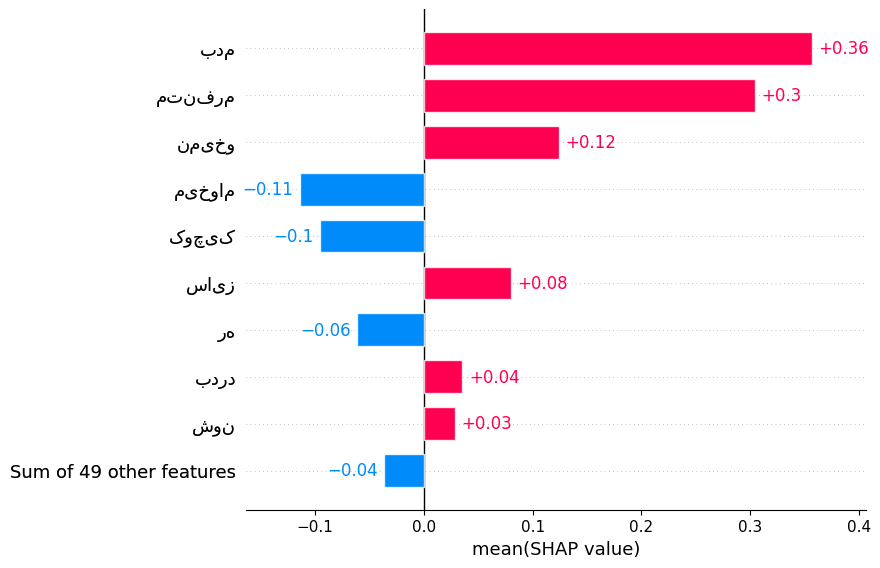

In [56]:
shap.plots.bar(shap_values[:, :, "LABEL_1"].mean(0))

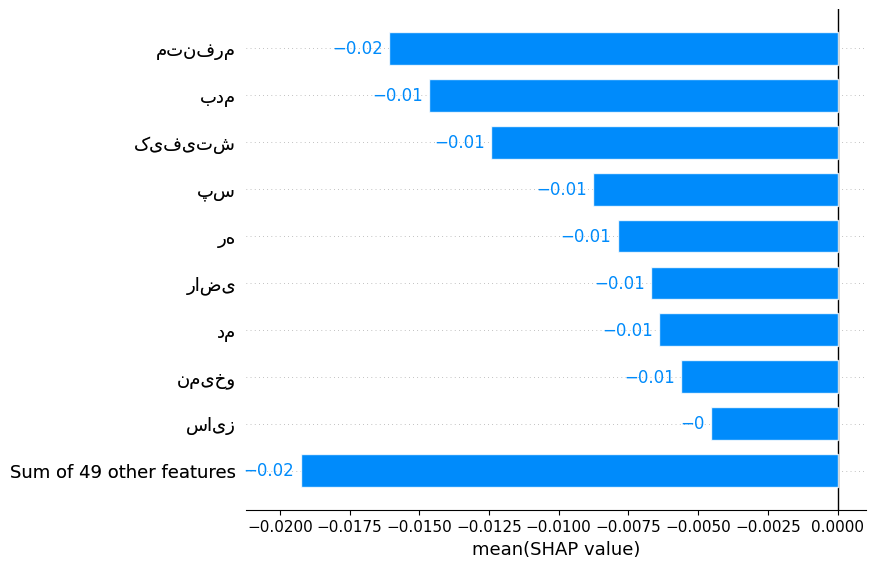

In [57]:
# we can sort the bar chart in decending order
shap.plots.bar(shap_values[:, :, "LABEL_3"].mean(0), order=shap.Explanation.argsort)

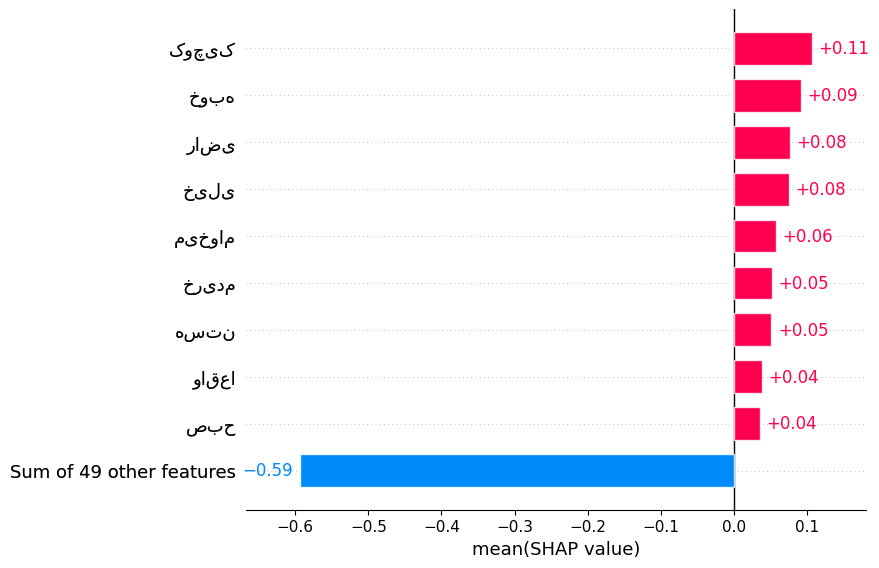

In [59]:
# ...or acending order
shap.plots.bar(shap_values[:, :, "LABEL_5"].mean(0), order=shap.Explanation.argsort.flip)

In [60]:
logit_explainer = shap.Explainer(shap.models.TransformersPipeline(pred, rescale_to_logits=True))

logit_shap_values = logit_explainer(df["tweets"][:3])
shap.plots.text(logit_shap_values)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [00:11, 11.35s/it]               
